# import lib

In [43]:
%run -i common_utils.ipynb

In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import numpy as np
import ast

In [63]:
%%HTML
<script src="require.js"></script>

# Read data 

In [3]:
df = pd.read_csv('conversation_after_eda.csv')
df.head(10)

turn_id  turn_timeout turn_error  \
0  f3bad83c-fc02-4dbf-9259-7c968a34b524         False        NaN   
1  59c0cdb3-6374-4160-8458-5b8f3f04f14e         False        NaN   
2  e1d9df56-ca79-4910-a9d8-764de23de21f         False        NaN   
3  29eae7f0-ff25-47d6-97f4-a3d3906177e7         False        NaN   
4  53ceb643-7fa9-44c5-859f-0951afb56f02         False        NaN   
5  1b23cfe1-ed38-44c2-b63d-d74f383f19d1         False        NaN   
6  3f48ba14-a78a-466a-b1b0-008f5d9550c4         False        NaN   
7  1cc334c1-b8f1-48a4-bfe9-2ddf19875a8f         False        NaN   
8  95b57335-0a48-4b4b-a31f-291bbcce4d1c         False        NaN   
9  6fe1a407-a3ee-4221-a8d9-a3efd08941c1         False        NaN   

                                         user_prompt  \
0          what do you think about hanson's robotics   
1  sure but will the robots have personalities of...   
2                                           i'm what   
3                   i need help with my mental house   
4               have you ever started it boarding it   
5                                                 no   
6                          order santa it's going on   
7                                                yes   
8  if i'm twelve years old how much caffeine shou...   
9            i like roblox games that are not roblox   

                                 candidate_responses  \
0  {"TOPIC_SELECTION_RESPONDER":"We can talk abou...   
1  {"EMPATHY_NRG":"I see. I think it would be rea...   
2  {"EMPATHY_NRG":"Ok. Do you like going to conce...   
3  {"EMPATHY_NRG":"I&apos;m sorry to hear that. C...   
4  {"EMPATHY_NRG":"That is a good point. Do you w...   
5  {"EMPATHY_NRG":"Got it... To try another socia...   
6  {"EMPATHY_NRG":"i could help if i could help. ...   
7  {"EMPATHY_NRG":"The first robots were created ...   
8  {"EMPATHY_NRG":"Caffeine is the most abundant ...   
9  {"EMPATHY_NRG":"I think I've heard of roblox, ...   

                                        bot_response  \
0  We can talk about books, movies, music, and mo...   
1  It's also helpful to keep in mind some strateg...   
2                                 i am ten years old   
3  It sounds like incorporating daily exercises l...   
4  Graphic novels are long-form fictional works o...   
5  It's great that you're taking steps to improve...   
6  &quot;Staying to a sleep schedule is important...   
7  ... breakthroughs and innovations happening ev...   
8  It's important to take the time to figure out ...   
9  In addition to those titles, Jesus is also ref...   

                               search_bot_api_output follow_up_flow  \
0  I think that's amazing! how did you come up wi...            NaN   
1  It's hard to say. it depends on how you define...           True   
2  i'm sorry, i didn't know that. i'll try to rem...           True   
3  Oh, i see. well, i guess i can see how that wo...           True   
4  It's good that you are both taking steps to im...           True   
5  It's great that you're taking steps to improve...           True   
6  You're right, it is going on. i'm glad you ask...           True   
7  It is good to learn about the history of robot...           True   
8  You should limit your caffeine intake to 400 m...           True   
9  i think that you should try the bank heist. it...           True   

                                     conversation_id          start_timestamp  \
0  d4c355da98ce66b013724122d71e5a68e00cb756f2e52e...  2023-04-26 16:40:37.152   
1  d4c355da98ce66b013724122d71e5a68e00cb756f2e52e...  2023-04-26 16:52:03.703   
2  d4c355da98ce66b013724122d71e5a68e00cb756f2e52e...  2023-04-26 16:52:25.912   
3  38ff3212c433a513bfdb72df204cae4687b3f2018ff13e...   2023-04-27 02:18:05.62   
4  38ff3212c433a513bfdb72df204cae4687b3f2018ff13e...  2023-04-27 02:19:16.021   
5  38ff3212c433a513bfdb72df204cae4687b3f2018ff13e...  2023-04-27 02:18:56.317   
6  e9afabe5a6a68921bbcd949bfa63bcb7a54d2bfc79e705...  2023-04-27 02:35:10.076   
7 

# Correlation

In [4]:
df.columns

Index(['turn_id', 'turn_timeout', 'turn_error', 'user_prompt',
       'candidate_responses', 'bot_response', 'search_bot_api_output',
       'follow_up_flow', 'conversation_id', 'start_timestamp', 'end_timestamp',
       'dialog_act_intent_dialogactintent', 'dialog_act_intent_topic',
       'ranker_input_dialog_context', 'ranker_input_responses',
       'candidate_responses_empathy_nrg',
       'candidate_responses_search_bot_responder', 'chatgpt_response',
       'conversation_id.1', 'approximate_start_time', 'rating',
       'conversationdurationinseconds', 'feedback', 'exception_caused_by',
       'candidate_responses_topic_selection_responder',
       'candidate_responses_atm5b_responder',
       'candidate_responses_atm20b_responder',
       'candidate_responses_stable_lm_responder',
       'candidate_responses_fun_fact_responder',
       'candidate_responses_top_three_responder',
       'candidate_responses_qa_responder',
       'candidate_responses_offensive_responder',
       '

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
df_dialog = df[~df['ranker_input_dialog_context'].isnull()]

In [7]:
df_dialog = df_dialog.rename({'chatgpt_response': 'candidate_responses_chatgpt_response', 'search_bot_api_output': 'candidate_responses_search_bot_api_output'}, axis=1)

In [8]:
df_dialog['dialog_context'] = df_dialog['ranker_input_dialog_context'].apply(lambda x: [s for c in ast.literal_eval(x) for s in c.values()])

In [9]:
df_dialog['context_embeddings'] = df_dialog.apply(lambda x: model.encode(' [SEP] '.join([str(y) for y in x['dialog_context'] + [x['user_prompt']]])), axis=1)

In [10]:
candidate_responder = ['candidate_responses_topic_selection_responder',
       'candidate_responses_atm5b_responder',
       'candidate_responses_atm20b_responder',
       'candidate_responses_stable_lm_responder',
       'candidate_responses_fun_fact_responder',
       'candidate_responses_top_three_responder',
       'candidate_responses_qa_responder',
       'candidate_responses_offensive_responder',
       'candidate_responses_sensitive_responder',
       'candidate_responses_nrg_responder',
       'candidate_responses_greetings_responder',
        'candidate_responses_empathy_nrg',
       'candidate_responses_search_bot_responder', 
        'candidate_responses_chatgpt_response',
        'candidate_responses_search_bot_api_output']

In [11]:
len(candidate_responder)

15

In [12]:
for resp in candidate_responder:
    df_dialog[resp + '_embeddings'] = df_dialog[resp].apply(lambda x: model.encode(str(x)))

In [13]:
for embedding in candidate_responder:
    name = embedding.replace('candidate_responses', 'cs')
    df_dialog[name] = df_dialog.apply(lambda x: cosine_similarity([x['context_embeddings']], [x[embedding + '_embeddings']])[0][0], axis=1)

In [14]:
df_dialog.columns

Index(['turn_id', 'turn_timeout', 'turn_error', 'user_prompt',
       'candidate_responses', 'bot_response',
       'candidate_responses_search_bot_api_output', 'follow_up_flow',
       'conversation_id', 'start_timestamp', 'end_timestamp',
       'dialog_act_intent_dialogactintent', 'dialog_act_intent_topic',
       'ranker_input_dialog_context', 'ranker_input_responses',
       'candidate_responses_empathy_nrg',
       'candidate_responses_search_bot_responder',
       'candidate_responses_chatgpt_response', 'conversation_id.1',
       'approximate_start_time', 'rating', 'conversationdurationinseconds',
       'feedback', 'exception_caused_by',
       'candidate_responses_topic_selection_responder',
       'candidate_responses_atm5b_responder',
       'candidate_responses_atm20b_responder',
       'candidate_responses_stable_lm_responder',
       'candidate_responses_fun_fact_responder',
       'candidate_responses_top_three_responder',
       'candidate_responses_qa_responder',
    

In [15]:
cosine_similarities = ['cs_topic_selection_responder', 'cs_atm5b_responder',
       'cs_atm20b_responder', 'cs_stable_lm_responder',
       'cs_fun_fact_responder', 'cs_top_three_responder', 'cs_qa_responder',
       'cs_offensive_responder', 'cs_sensitive_responder', 'cs_nrg_responder',
       'cs_greetings_responder', 'cs_empathy_nrg', 'cs_search_bot_responder',
       'cs_chatgpt_response', 'cs_search_bot_api_output']

In [16]:
len(cosine_similarities)

15

In [17]:
df_dialog[cosine_similarities]

cs_topic_selection_responder  cs_atm5b_responder  cs_atm20b_responder  \
0                         0.052795            0.170883             0.342315   
1                         0.130079            0.130079             0.624512   
2                         0.117193            0.053764             0.205902   
3                         0.029806            0.151651             0.281310   
4                         0.029806            0.201638             0.120553   
...                            ...                 ...                  ...   
3754                      0.070392            0.335705            -0.018831   
3755                      0.052437            0.244132             0.412937   
3756                      0.039594            0.440332             0.461219   
3757                     -0.029104           -0.089143             0.126966   
3758                     -0.014972            0.430526             0.450408   

      cs_stable_lm_responder  cs_fun_fact_responder  cs_top_three_responder  \
0                   0.188422               0.379825                0.188422   
1                   0.130079               0.130079                0.130079   
2                   0.117193               0.117193                0.117193   
3                   0.029806               0.029806                0.029806   
4                   0.029806               0.029806                0.029806   
...                      ...                    ...                     ...   
3754                0.070392               0.070392                0.070392   
3755                0.052437               0.052437                0.052437   
3756                0.039594               0.039594                0.039594   
3757               -0.029104              -0.029104               -0.029104   
3758               -0.014972              -0.014972               -0.014972   

      cs_qa_responder  cs_offensive_responder  cs_sensitive_responder  \
0            0.188422                0.188422                0.188422   
1            0.130079                0.130079                0.130079   
2            0.117193                0.117193                0.117193   
3            0.029806                0.029806                0.029806   
4            0.029806                0.029806                0.029806   
...               ...                     ...                     ...   
3754         0.070392                0.070392                0.083867   
3755         0.052437                0.052437                0.181977   
3756         0.039594                0.039594                0.039594   
3757        -0.029104               -0.029104               -0.029104   
3758        -0.014972               -0.014972               -0.014972   

      cs_nrg_responder  cs_greetings_responder  cs_empathy_nrg  \
0             0.188422                0.188422        0.040562   
1             0.130079                0.130079        0.211238   
2             0.117193                0.117193        0.130622   
3             0.029806                0.029806        0.051061   
4             0.029806                0.029806        0.276472   
...                ...                     ...             ...   
3754          0.070392                0.070392       -0.007366   
3755          0.052437                0.052437        0.022524   
3756          0.039594                0.039594        0.071808   
3757         -0.029104               -0.029104        0.005995   
3758         -0.014972               -0.014972       -0.063610   

      cs_search_bot_responder  cs_chatgpt_response  cs_search_bot_api_output  
0                    0.214469             0.188422                  0.214469  
1                    0.130547             0.088444                  0.130547  
2                    0.081057             0.117193                  0.081057  
3                    0.213166             0.094616                  0.213166  
4                    0.102088             0

In [18]:
heatmap_corr(df_dialog[['cs_topic_selection_responder', 'cs_atm5b_responder',
       'cs_atm20b_responder', 'cs_stable_lm_responder',
       'cs_fun_fact_responder', 'cs_top_three_responder', 'cs_qa_responder',
       'cs_offensive_responder', 'cs_sensitive_responder', 'cs_nrg_responder',
       'cs_greetings_responder', 'cs_empathy_nrg', 'cs_search_bot_responder', 'rating']])

In [19]:
df_dialog['high_similarity_candidate'] = df_dialog[cosine_similarities].idxmax(axis=1)

In [39]:
df_dialog['high_cs_score'] = df_dialog[cosine_similarities].max(axis=1)

In [128]:
for resp in candidate_responder:
    df_dialog.loc[df_dialog.apply(lambda row: str(row[resp]) in str(row['bot_response']) or 
                                  str(row['bot_response']) in str(row[resp]), axis=1), 
                  'chosen_responder'] = resp.replace('candidate_responses_', '')

In [129]:
df_dialog['high_similarity_candidate'] = df_dialog['high_similarity_candidate'].str.replace('cs_', '')

In [130]:
candidate_responder

['candidate_responses_topic_selection_responder',
 'candidate_responses_atm5b_responder',
 'candidate_responses_atm20b_responder',
 'candidate_responses_stable_lm_responder',
 'candidate_responses_fun_fact_responder',
 'candidate_responses_top_three_responder',
 'candidate_responses_qa_responder',
 'candidate_responses_offensive_responder',
 'candidate_responses_sensitive_responder',
 'candidate_responses_nrg_responder',
 'candidate_responses_greetings_responder',
 'candidate_responses_empathy_nrg',
 'candidate_responses_search_bot_responder',
 'candidate_responses_chatgpt_response',
 'candidate_responses_search_bot_api_output']

In [131]:
for resp in candidate_responder:
    df_dialog.loc[df_dialog.apply(lambda row: str(row[resp]) in str(row['bot_response']) or 
                                  str(row['bot_response']) in str(row[resp]), axis=1), 
                  'cs_of_chosen_responder'] = df_dialog[resp.replace('candidate_responses', 'cs')]

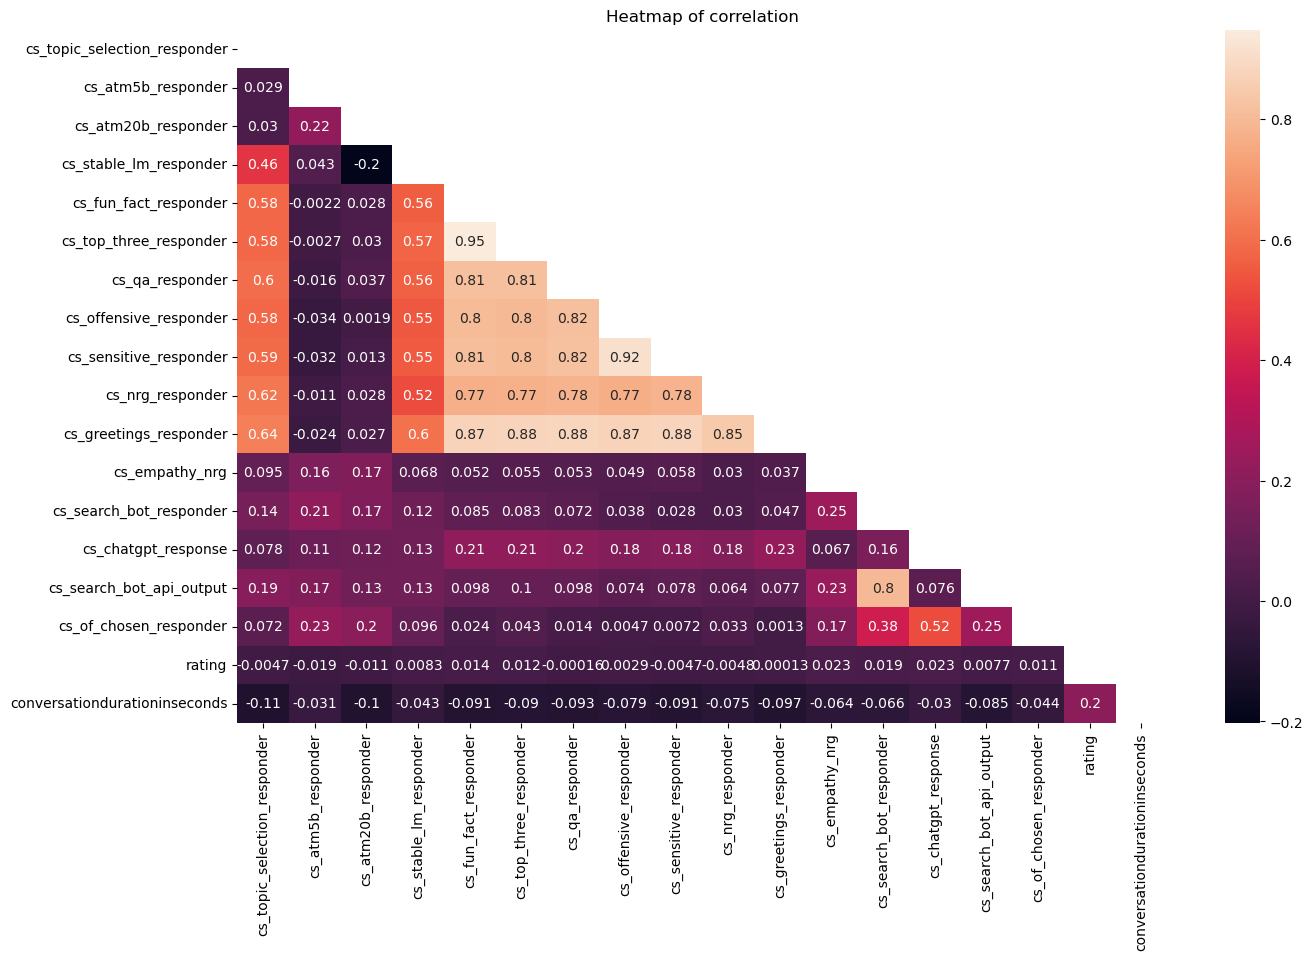

In [148]:
heatmap_corr(df_dialog[cosine_similarities + ['cs_of_chosen_responder', 'rating', 'conversationdurationinseconds']])

In [126]:
df_dialog['rating'] = round(df['rating'])

In [133]:
eda_1d_categorical_column(df_dialog, 'chosen_responder')


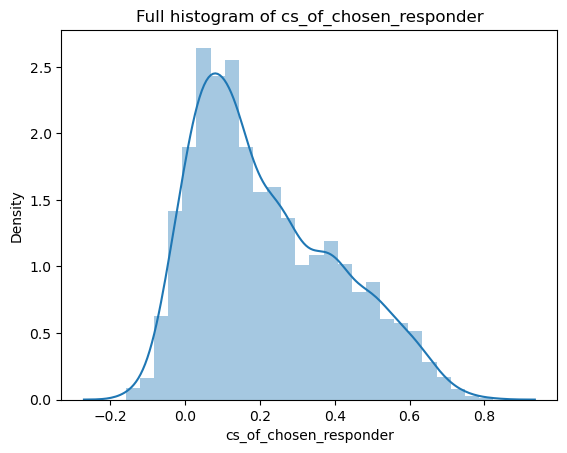
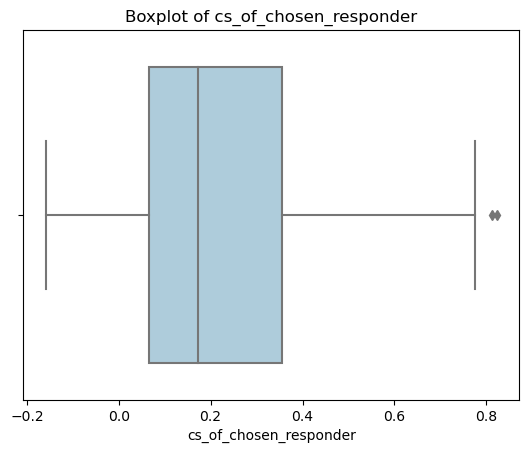

In [134]:
eda_1d_numerical_column(df_dialog, 'cs_of_chosen_responder')

In [135]:
eda_2d_categorical_numerical_column(df_dialog, 'rating', 'cs_of_chosen_responder')

In [136]:
eda_2d_categorical_numerical_column(df_dialog, 'rating', 'high_cs_score')

In [137]:
describe_2d_cate_label(df_dialog, 'rating', 'chosen_responder')

rating           chosen_responder  count  %chosen_responder_by_rating  \
0      1.0           atm20b_responder     42                         5.63   
1      1.0            atm5b_responder     26                         3.49   
2      1.0           chatgpt_response    381                        51.07   
3      1.0                empathy_nrg     25                         3.35   
4      1.0         fun_fact_responder      1                         0.13   
..     ...                        ...    ...                          ...   
63     5.0       search_bot_responder     53                         5.46   
64     5.0        sensitive_responder     24                         2.47   
65     5.0        stable_lm_responder     26                         2.68   
66     5.0  topic_selection_responder     55                         5.66   
67     5.0                        NaN     33                         3.40   

    %rating_by_chosen_responder  
0                         18.83  
1                         16.88  
2                         20.66  
3                         23.81  
4                         50.00  
..                          ...  
63                        28.96  
64                        26.37  
65                        22.61  
66                        26.32  
67                          NaN  

[68 rows x 5 columns]

In [138]:
describe_2d_cate_label(df_dialog, 'chosen_responder', 'rating')

chosen_responder  rating  count  %rating_by_chosen_responder  \
0   atm20b_responder     1.0     42                        18.83   
1   atm20b_responder     2.0     44                        19.73   
2   atm20b_responder     3.0     30                        13.45   
3   atm20b_responder     4.0     45                        20.18   
4   atm20b_responder     5.0     62                        27.80   
..               ...     ...    ...                          ...   
63               NaN     1.0     30                          NaN   
64               NaN     2.0     19                          NaN   
65               NaN     3.0     16                          NaN   
66               NaN     4.0     13                          NaN   
67               NaN     5.0     33                          NaN   

    %chosen_responder_by_rating  
0                          5.63  
1                          6.97  
2                          5.05  
3                          6.77  
4                          6.39  
..                          ...  
63                         4.02  
64                         3.01  
65                         2.69  
66                         1.95  
67                         3.40  

[68 rows x 5 columns]

In [139]:
eda_1d_categorical_column(df_dialog, 'high_similarity_candidate')

In [141]:
df_dialog[df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder']].shape

(463, 71)

In [140]:
eda_1d_categorical_column(df_dialog[df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder']], 'high_similarity_candidate')

In [142]:
eda_1d_categorical_column(df_dialog[(df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder']) & (df_dialog['rating'].between(3, 5))], 'high_similarity_candidate')

In [143]:
eda_1d_categorical_column(df_dialog[df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder']], 'dialog_act_intent_dialogactintent')

In [144]:
eda_1d_categorical_column(df_dialog[(df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder'])  & (df_dialog['rating'].between(3, 5))], 'dialog_act_intent_dialogactintent')

In [145]:
eda_1d_categorical_column(df_dialog[df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder']], 'dialog_act_intent_topic')

In [146]:
eda_1d_categorical_column(df_dialog[(df_dialog['high_similarity_candidate'] == df_dialog['chosen_responder'])], 'rating')

In [147]:
for rating in range(1, 6, 1):
    print("Rating = ", rating)
    describe_2d_cate_label(df_dialog[df_dialog['rating'] == rating], 'dialog_act_intent_topic', 'chosen_responder')

Rating =  1


dialog_act_intent_topic       chosen_responder  count  \
0      Entertainment_Books       atm20b_responder      4   
1      Entertainment_Books        atm5b_responder      1   
2      Entertainment_Books       chatgpt_response     14   
3      Entertainment_Books            empathy_nrg      1   
4      Entertainment_Books           qa_responder      1   
..                     ...                    ...    ...   
81                  Sports           qa_responder      1   
82                  Sports  search_bot_api_output      1   
83                  Sports    stable_lm_responder      2   
84                  Sports                    NaN      1   
85                     NaN  search_bot_api_output      1   

    %chosen_responder_by_dialog_act_intent_topic  \
0                                          12.50   
1                                           3.12   
2                                          43.75   
3                                           3.12   
4                                           3.12   
..                                           ...   
81                                          9.09   
82                                          9.09   
83                                         18.18   
84                                          9.09   
85                                           NaN   

    %dialog_act_intent_topic_by_chosen_responder  
0                                           9.52  
1                                           3.85  
2                                           3.67  
3                                           4.00  
4                                           8.33  
..                                           ...  
81                                          8.33  
82                                          1.09  
83                                         11.11  
84                                           NaN  
85                                          1.09  

[86 rows x 5 columns]

Rating =  2


dialog_act_intent_topic           chosen_responder  count  \
0      Entertainment_Books           atm20b_responder      2   
1      Entertainment_Books            atm5b_responder      1   
2      Entertainment_Books           chatgpt_response     23   
3      Entertainment_Books                empathy_nrg      2   
4      Entertainment_Books      search_bot_api_output      7   
..                     ...                        ...    ...   
69  Science_and_Technology  topic_selection_responder      1   
70                  Sports           chatgpt_response     10   
71                  Sports                empathy_nrg      2   
72                  Sports               qa_responder      1   
73                  Sports      search_bot_api_output      2   

    %chosen_responder_by_dialog_act_intent_topic  \
0                                           5.00   
1                                           2.50   
2                                          57.50   
3                                           5.00   
4                                          17.50   
..                                           ...   
69                                          2.44   
70                                         66.67   
71                                         13.33   
72                                          6.67   
73                                         13.33   

    %dialog_act_intent_topic_by_chosen_responder  
0                                           4.55  
1                                           4.17  
2                                           7.35  
3                                           9.52  
4                                           7.45  
..                                           ...  
69                                          2.63  
70                                          3.19  
71                                          9.52  
72                                         11.11  
73                                          2.13  

[74 rows x 5 columns]

Rating =  3


dialog_act_intent_topic       chosen_responder  count  \
0      Entertainment_Books       atm20b_responder      1   
1      Entertainment_Books       chatgpt_response     31   
2      Entertainment_Books            empathy_nrg      2   
3      Entertainment_Books          nrg_responder      1   
4      Entertainment_Books    offensive_responder      1   
..                     ...                    ...    ...   
77                  Sports           qa_responder      2   
78                  Sports  search_bot_api_output      6   
79                  Sports   search_bot_responder      1   
80                  Sports    stable_lm_responder      2   
81                     NaN  search_bot_api_output      1   

    %chosen_responder_by_dialog_act_intent_topic  \
0                                           2.22   
1                                          68.89   
2                                           4.44   
3                                           2.22   
4                                           2.22   
..                                           ...   
77                                          8.70   
78                                         26.09   
79                                          4.35   
80                                          8.70   
81                                           NaN   

    %dialog_act_intent_topic_by_chosen_responder  
0                                           3.33  
1                                          10.26  
2                                          15.38  
3                                          33.33  
4                                          20.00  
..                                           ...  
77                                         14.29  
78                                          8.33  
79                                          4.17  
80                                          5.71  
81                                          1.39  

[82 rows x 5 columns]

Rating =  4


dialog_act_intent_topic      chosen_responder  count  \
0      Entertainment_Books      atm20b_responder      5   
1      Entertainment_Books       atm5b_responder      1   
2      Entertainment_Books      chatgpt_response     24   
3      Entertainment_Books           empathy_nrg      1   
4      Entertainment_Books          qa_responder      1   
..                     ...                   ...    ...   
70                  Sports           empathy_nrg      1   
71                  Sports          qa_responder      1   
72                  Sports  search_bot_responder      3   
73                  Sports                   NaN      1   
74                     NaN      chatgpt_response      1   

    %chosen_responder_by_dialog_act_intent_topic  \
0                                          10.42   
1                                           2.08   
2                                          50.00   
3                                           2.08   
4                                           2.08   
..                                           ...   
70                                          3.45   
71                                          3.45   
72                                         10.34   
73                                          3.45   
74                                           NaN   

    %dialog_act_intent_topic_by_chosen_responder  
0                                          11.11  
1                                           3.45  
2                                           6.90  
3                                           4.76  
4                                           6.67  
..                                           ...  
70                                          4.76  
71                                          6.67  
72                                          8.82  
73                                           NaN  
74                                          0.29  

[75 rows x 5 columns]

Rating =  5


dialog_act_intent_topic       chosen_responder  count  \
0      Entertainment_Books       atm20b_responder      6   
1      Entertainment_Books        atm5b_responder      2   
2      Entertainment_Books       chatgpt_response     42   
3      Entertainment_Books            empathy_nrg      1   
4      Entertainment_Books           qa_responder      1   
..                     ...                    ...    ...   
79                  Sports       chatgpt_response     16   
80                  Sports            empathy_nrg      1   
81                  Sports  search_bot_api_output      3   
82                  Sports   search_bot_responder      1   
83                  Sports                    NaN      1   

    %chosen_responder_by_dialog_act_intent_topic  \
0                                           7.79   
1                                           2.60   
2                                          54.55   
3                                           1.30   
4                                           1.30   
..                                           ...   
79                                         66.67   
80                                          4.17   
81                                         12.50   
82                                          4.17   
83                                          4.17   

    %dialog_act_intent_topic_by_chosen_responder  
0                                           9.68  
1                                           4.44  
2                                           8.40  
3                                           4.00  
4                                           8.33  
..                                           ...  
79                                          3.20  
80                                          4.00  
81                                          2.48  
82                                          1.89  
83                                           NaN  

[84 rows x 5 columns]

In [64]:
!jupyter nbconvert --to html --no-input Correlation.ipynb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[NbConvertApp] Converting notebook Correlation.ipynb to html
[NbConvertApp] Writing 1376441 bytes to Correlation.html


In [41]:
df_dialog.to_csv('correlation_cs.csv', index=None)